In [1]:
import matplotlib.pyplot as plt
from IPython.display import clear_output
from matplotlib.animation import FuncAnimation, ArtistAnimation
from scipy.constants import hbar
#from rydbperc.cython_utilities import util
from rydbperc import ryperc
from rydbperc import twoatoms
import numpy as np

In [2]:
def experiment(
        N_points = 5000,
        detuning_IR = 25, # detuning [MHz]
        dt = 1, # [us]
        evo_time = 1500, # [us]
        power_blue = 1.5e-3,
        waste_blue = 40e-6,
        power_IR = 40e-3,
        waste_IR = 100e-6,
        detuning_blue = 400,
        p_facilitation = 0,
        shape = [80,80,80], # shape MOT in microns
        repetitions = 10
        ):
    if detuning_IR == 0:
        detuning_IR = 0.001

    text = "simulation parameters:\n"
    text += "detuning from Rydberg = %.1f \n"%detuning_IR

    C6 = 0.870 *10**6
    gamma_def = 4.4 # [MHz]
    radius_shell = (C6/(detuning_IR))**(1/6)
    delta_radius_shell = radius_shell*(gamma_def/(6*detuning_IR))

    text += "facilitation shell radius and delta = %.1f +- %.4f \n" %(radius_shell,delta_radius_shell/2)

    N_steps = int(evo_time/dt)

    atom = twoatoms.single_atom(power_blue, waste_blue, power_IR, waste_IR, detuning_blue, detuning_IR=detuning_IR)#, power_depumping=10e-3, waste_depumping=100e-6)
    rho0 = np.zeros([4,4])
    rho0[0,0] = 1
    steps = 10000
    time = dt
    atom.evolve(time, steps, rho0)

    text += "two photon rabi freq. = %.3f MHz\n"%atom.two_photon_rabi_freq

    radius_blokade = atom.radius_blokade
    text += "blokade radius = %.1f um\n" %(atom.radius_blokade)
    text += "number of steps = %d \n"%N_steps

    p_spont_exc = atom.get_excitation_probability()
    p_spont_emi = atom.Gamma_70s * dt

    text += "probabiliy of one atom in one step of:\n"
    text += " . spontaneous excitation  = %.4f \n"%(p_spont_exc*N_steps)
    text += " . spontaneous emission = %.4f \n"%p_spont_emi
    text += " . facilitated excitation = %.4f \n"%p_facilitation

    density = N_points/(shape[0]*shape[1]*shape[2]*10**-2) # atoms/cm^3

    text += "mean density = %.1f 10^10\n"%density
    print(text)
    excs = []
    for _ in range(repetitions):
        clear_output(wait=True)
        print(text, "status: %.1f %%"%_)
        clu = ryperc.cluster3D(N_points, shape, distribution="uniform")

        clu.set_evolution_parameters(
                                    shell_radius=radius_shell, 
                                    shell_delta=delta_radius_shell, 
                                    blokade_radius=radius_blokade,
                                    p_spont_exct=p_spont_exc, 
                                    p_emission=p_spont_emi, 
                                    p_fac=p_facilitation
                                    )

        excs.append(clu.evolve(N_steps))
    return np.mean(excs, axis=0), np.std(excs, axis=0)

In [3]:
evo_time = 1500
dt = 1

res, res_std = experiment(
        N_points = 5000,
        detuning_IR = 100, # detuning [MHz]
        dt = dt, # [us]
        evo_time = evo_time, # [us]
        power_blue = 1.5e-3,
        waste_blue = 40e-6,
        power_IR = 40e-3,
        waste_IR = 100e-6,
        detuning_blue = 400,
        p_facilitation = 0,
        shape = [80,80,80], # shape MOT in microns
        repetitions = 10
        )

simulation parameters:
detuning from Rydberg = 100.0 
facilitation shell radius and delta = 4.5 +- 0.0166 
two photon rabi freq. = 0.309 MHz
blokade radius = 11.9 um
number of steps = 1500 
probabiliy of one atom in one step of:
 . spontaneous excitation  = 0.0061 
 . spontaneous emission = 0.0027 
 . facilitated excitation = 0.0000 
mean density = 1.0 10^10
 status: 9.0 %


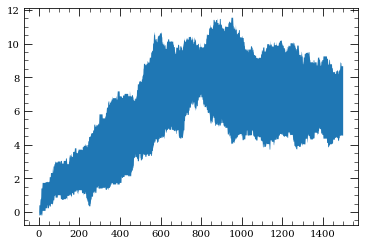

In [37]:
x = np.linspace(0, evo_time, len(res))
plt.fill_between(x, res-res_std, res+res_std)
plt.show()

In [6]:
detunings = np.linspace(0.01, 80, 10)
N_points = 5000
evo_time = 100
res1 = []
for detuning_IR in detunings:
    print(detuning_IR)
    res1.append(experiment(evo_time=evo_time, detuning_IR=detuning_IR)[-1])

simulation parameters:
detuning from Rydberg = 80.0 
facilitation shell radius and delta = 4.7 +- 0.0216 
blokade radius = 11.9 um
number of steps = 100 
probabiliy of one atom in one step of:
 . spontaneous excitation  = 0.0006 
 . spontaneous emission = 0.0027 
 . facilitated excitation = 0.0000 
mean density = 1.0 10^10
 status: 9.0 %


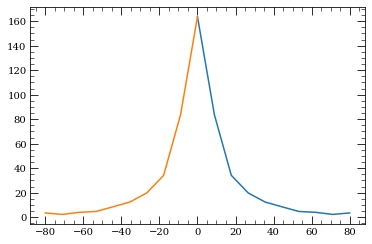

In [7]:
plt.plot(detunings, res1)
plt.plot(-detunings, res1)
plt.show()

In [8]:
detunings = np.linspace(1, 80, 10)
N_points = 1000
evo_time = 100
res1 = []
for detuning_IR in detunings:
    print(detuning_IR)
    res1.append(experiment(evo_time=evo_time, p_facilitation=0.2, detuning_IR=detuning_IR)[-1])

simulation parameters:
detuning from Rydberg = 80.0 
facilitation shell radius and delta = 4.7 +- 0.0216 
blokade radius = 11.9 um
number of steps = 100 
probabiliy of one atom in one step of:
 . spontaneous excitation  = 0.0006 
 . spontaneous emission = 0.0027 
 . facilitated excitation = 0.2000 
mean density = 1.0 10^10
 status: 9.0 %


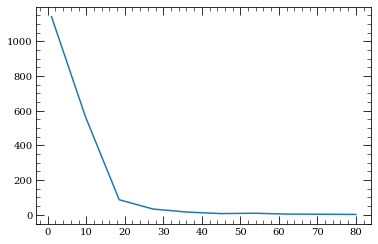

In [9]:
plt.plot(detunings, res1)
#plt.plot(-detunings, res1)
plt.show()

In [21]:
detuning_IR = 80
N_points = 1000
evo_time = 1000
res1 = []
p_facs = np.linspace(0,0.2, 10)
for p_facilitation in p_facs:
    res1.append(experiment(N_points = N_points, evo_time=evo_time, p_facilitation=p_facilitation, detuning_IR=detuning_IR)[-1])
    print(p_facilitation)

simulation parameters:
detuning from Rydberg = 80.0 
facilitation shell radius and delta = 4.7 +- 0.0216 
blokade radius = 11.9 um
number of steps = 1000 
probabiliy of one atom in one step of:
 . spontaneous excitation  = 0.0061 
 . spontaneous emission = 0.0027 
 . facilitated excitation = 0.2000 
mean density = 0.2 10^10
 status: 9.0 %
0.2


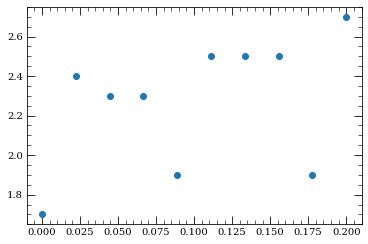

In [22]:
plt.plot(p_facs, res1, "o")
#plt.plot(-detunings, res1)
plt.show()

In [12]:
hbar*(2*np.pi/1013+2*np.pi/420)*10**9/(2.4 * 10**-25)

0.009298914238853243

In [13]:
hbar*2*np.pi

6.62607015e-34